In [56]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time
import math

from datetime import datetime


# Main Algorithm

In [57]:
class demand_object:
    def __init__(self, index, interarrival_time, x_coordinate, y_coordinate, service_time, earliest_arrival):
        self.index = index
        self.interarrival_time = interarrival_time
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival

def wait_for_arrival():
    global lam; global mu; global m; global number_nodes_in_system; global lower_earliest; global sigma
    global all_demands
    
    np.random.seed(number_nodes_in_system)

    A = np.random.exponential(scale = 1/lam, size=1)[0];
    #S = mu
    S = np.random.uniform(0, 1, size = 1)[0]
    X = np.random.uniform(low=0, high=m, size=1)[0];
    Y = np.random.uniform(low=0, high=m, size=1)[0];
    demand = demand_object(number_nodes_in_system+1, A, X, Y, S, lower_earliest + A);
    
    all_demands[number_nodes_in_system] = demand
    return demand;

def add_newly_appeared(available_nodes, current_time):
    global number_available_nodes
    global number_nodes_in_system
    global lower_earliest
    
    while (number_nodes_in_system < simulation_demands_amount):
        new_available_node = wait_for_arrival();
        if (new_available_node.earliest_arrival <= current_time):
            available_nodes.append(new_available_node);
            number_available_nodes += 1;
            number_nodes_in_system += 1;
            lower_earliest = new_available_node.earliest_arrival;
        else:
            break
        
    return available_nodes;

def determine_Nearest_Neighbor(available_nodes, current_node):
    minimum_distance = np.sqrt(((current_node.x_coordinate - available_nodes[0].x_coordinate)**2) + ((current_node.y_coordinate - available_nodes[0].y_coordinate)**2));
    next_node = available_nodes[0]
    
    for demand in available_nodes:
        temp_distance = np.sqrt(((current_node.x_coordinate - demand.x_coordinate)**2) + ((current_node.y_coordinate - demand.y_coordinate)**2));
                
        if (temp_distance < minimum_distance):
            next_node = demand;
            minimum_distance = temp_distance;
    
    travel_time = minimum_distance
    return next_node, travel_time;

def preemption_check(action_traveler, status_traveler, available_nodes, current_node, next_node, travel_current_round, current_time, travel_time, time_waited_at_depot):
    # If there appears a node while traveling, decide to go there instead of continueing the route
    # One route diversion allowed"""
    global number_available_nodes;
    global number_nodes_in_system
    global lower_earliest
    m = 1
    
    prev_num_available_nodes = number_available_nodes;
    time_start_travel = current_time + time_waited_at_depot;
    
    time_start_travel_test = current_time + time_waited_at_depot;
    
    available_nodes = add_newly_appeared(available_nodes, time_start_travel+travel_time);
    
    if (prev_num_available_nodes < number_available_nodes):
        for k in range(prev_num_available_nodes, number_available_nodes):
            time_traveled = available_nodes[k].earliest_arrival - time_start_travel;
            fraction_traveled_time = time_traveled/travel_time
            
            if (action_traveler == 1 and status_traveler == 1):
                position_repairman = [current_node.x_coordinate + (fraction_traveled_time*((m/2) - current_node.x_coordinate)), current_node.y_coordinate + (fraction_traveled_time*((m/2)-current_node.y_coordinate))]
                distance_original = np.sqrt(((position_repairman[0] - (m/2))**2) + ((position_repairman[1] - (m/2))**2))

            elif (action_traveler == 0 and status_traveler == 0):
                position_repairman = [(m/2) + (fraction_traveled_time*(next_node.x_coordinate-(m/2))), (m/2) + (fraction_traveled_time*(next_node.y_coordinate - (m/2)))]
                distance_original = np.sqrt(((position_repairman[0] - next_node.x_coordinate)**2) + ((position_repairman[1] - next_node.y_coordinate)**2))

            elif (action_traveler == 0 and status_traveler == 1):
                position_repairman = [current_node.x_coordinate + (fraction_traveled_time*(next_node.x_coordinate-current_node.x_coordinate)), current_node.y_coordinate + (fraction_traveled_time*(next_node.y_coordinate-current_node.y_coordinate))]
                distance_original = np.sqrt(((position_repairman[0] - next_node.x_coordinate)**2) + ((position_repairman[1] - next_node.y_coordinate)**2))

            else:
                raise ValueError(f"action_traveler == 1 and status_traveler == 0")

            distance_appeared = np.sqrt(((position_repairman[0] - available_nodes[k].x_coordinate)**2) + ((position_repairman[1] - available_nodes[k].y_coordinate)**2))
                                
            if (distance_appeared < distance_original or action_traveler == 1):

                # Remove nodes if they arrived after the updated arrival time 
                if (k < number_available_nodes):
                    to_be_removed = []
                    most_recent_added = available_nodes[k]
                    for l in range(k+1, number_available_nodes):
                        if (available_nodes[l].earliest_arrival > time_start_travel + time_traveled + distance_appeared):
                            to_be_removed.append(available_nodes[l])
                        else:
                            most_recent_added = available_nodes[l]
                        
                    if (len(to_be_removed)>0):
                        number_available_nodes -= len(to_be_removed)
                        number_nodes_in_system -= len(to_be_removed)
                        
                        for node in to_be_removed:
                            available_nodes.remove(node)
                            
                if (action_traveler == 0):
                    available_nodes.append(next_node);
                    number_available_nodes += 1
                    
                # Update next_node
                next_node = available_nodes[k];
                lower_earliest = most_recent_added.earliest_arrival
                available_nodes.remove(next_node);
                number_available_nodes -= 1
                
                time_start_travel_test = time_start_travel_test + time_traveled
                
                travel_current_round = time_waited_at_depot + time_traveled + distance_appeared;
                travel_time = time_traveled + distance_appeared

                action_traveler = 0;
                return next_node, travel_current_round, action_traveler, available_nodes, travel_time, time_start_travel_test;
    
    return next_node, travel_current_round, action_traveler, available_nodes, travel_time, time_start_travel_test;

def simulate_NN_variations_algorithm():
    global simulation_demands_amount; global m;
    global number_available_nodes; global number_nodes_in_system; global lower_earliest;
    
    result_waiting_times_array = [0]*simulation_demands_amount
    
    action_traveler = 0; # 0 = traveling to an available demand; 1 = travel to the depot
    status_traveler = 0; # 0 = at depot waiting; 1 = finished serving at a demand
    
    current_node = demand_object(0,0,m/2,m/2,0,0)
    
    number_visited_nodes = 0;
    available_nodes = [];
    
    current_time = 0.0;    
    start_time_time = time.time()
    
    while (number_visited_nodes < simulation_demands_amount):        
        
        #"""STATUS PRINTING"""
        if ((time.time()-start_time_time)/60 >= 0.5):
            now = datetime.now()
            now_time = now.strftime("%H:%M:%S")
            print(f"{now_time}: NUMBER DEMANDS VISITED: {number_visited_nodes}/{simulation_demands_amount}")
            start_time_time = time.time()
        #"""STATUS PRINTING"""
        
        # Initialization        
        available_nodes = add_newly_appeared(available_nodes, current_time);
        
        
        
        #"""THE SERVER IS AT THE DEPOT"""
        if (status_traveler == 0):
            # If currently at depot, wait for next node to become available
            next_node = wait_for_arrival();
            lower_earliest = next_node.earliest_arrival;
            number_nodes_in_system += 1;
            travel_time = np.sqrt(((next_node.x_coordinate - (m/2))**2) + ((next_node.y_coordinate - (m/2))**2))
            time_waited_at_depot = next_node.earliest_arrival - current_time;
            action_traveler = 0;
            
            if (time_waited_at_depot < 0):
                raise ValueError(f"Time waited at depot negative")
            
        else:
            time_waited_at_depot = 0.0;
            
            if (number_available_nodes == 0):
                # Return to the depot if there are no available demands
                time_start_travel = current_time
                travel_time = np.sqrt(((current_node.x_coordinate - (m/2))**2) + ((current_node.y_coordinate - (m/2))**2))
                action_traveler = 1
            
            else:
                # Determine next Nearest Neighbor
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes, current_node);
                available_nodes.remove(next_node);
                number_available_nodes -= 1;
                action_traveler = 0;
                
        travel_current_round = time_waited_at_depot + travel_time           

        # PREEMPTION CHECK
        next_node, travel_current_round, action_traveler, available_nodes, travel_time, time_start_travel_test = preemption_check(action_traveler, status_traveler, available_nodes, current_node, next_node, travel_current_round, current_time, travel_time, time_waited_at_depot)

        if (action_traveler == 0):
            # UPDATES
            prev_current_time = current_time
            result_waiting_times_array[number_visited_nodes] = current_time + travel_current_round - next_node.earliest_arrival
            current_time += travel_current_round + next_node.service_time;
            current_node = next_node;
            number_visited_nodes += 1;
            status_traveler = 1
            
        else:
            current_time += travel_current_round;
            status_traveler = 0;

    return result_waiting_times_array;

## Running Algorithm

In [58]:
# parameters
system_loads = 0.3
simulation_demands_amount = 400000 #Choose 1000000 or 400000 - Maximum number of demands per simulation
m = 1 # Square region A has size m x m
#mu = 1/10;
mu = 1/2;
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;

number_available_nodes = 0;
number_nodes_in_system = 0;
lower_earliest = 0.0;

all_demands = [None]*simulation_demands_amount

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")
start_time = time.time() # START TIME

#%timeit result = simulate_NN_variations_algorithm();
result_waiting_times_array = simulate_NN_variations_algorithm();

print(f"I have finished in {(time.time() - start_time)/60} minutes")


Starting time = 15:43:30
15:44:00: NUMBER DEMANDS VISITED: 359311/400000
I have finished in 0.5576899170875549 minutes


## Results - Waiting Times - Batch Means

In [59]:
if (simulation_demands_amount == 400000):
    warm_up_period_min = 200000
    warm_up_period_max = 320000
    sample_size = 3000
elif (simulation_demands_amount == 1000000):
    warm_up_period_min = 500000
    warm_up_period_max = 800000
    sample_size = 7500
else:
    raise ValueError(f"Invalid simulation amount")

number_of_samples = int((warm_up_period_max-warm_up_period_min)/sample_size)
print(f"number of samples = {number_of_samples}")


batch_sample = []
for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
    
CI_batches = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
sigma_batches = (statistics.stdev(batch_sample))

sigma_wait = (statistics.stdev(result_waiting_times_array[warm_up_period_min:warm_up_period_max]))


print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Sigma waiting time = {sigma_wait:.4f}")
print(f"CI Batches = [{CI_batches[0]:.4f},{CI_batches[1]:.4f}]")

number of samples = 40
Waiting time mean = 1.0029
Sigma waiting time = 1.0913
CI Batches = [0.9904,1.0153]


# Plotting

In [60]:
convergence = []
convergence_sum = 0.0;

for k in range(simulation_demands_amount):
    convergence_sum += result_waiting_times_array[k]
    convergence.append(convergence_sum/(k+1))

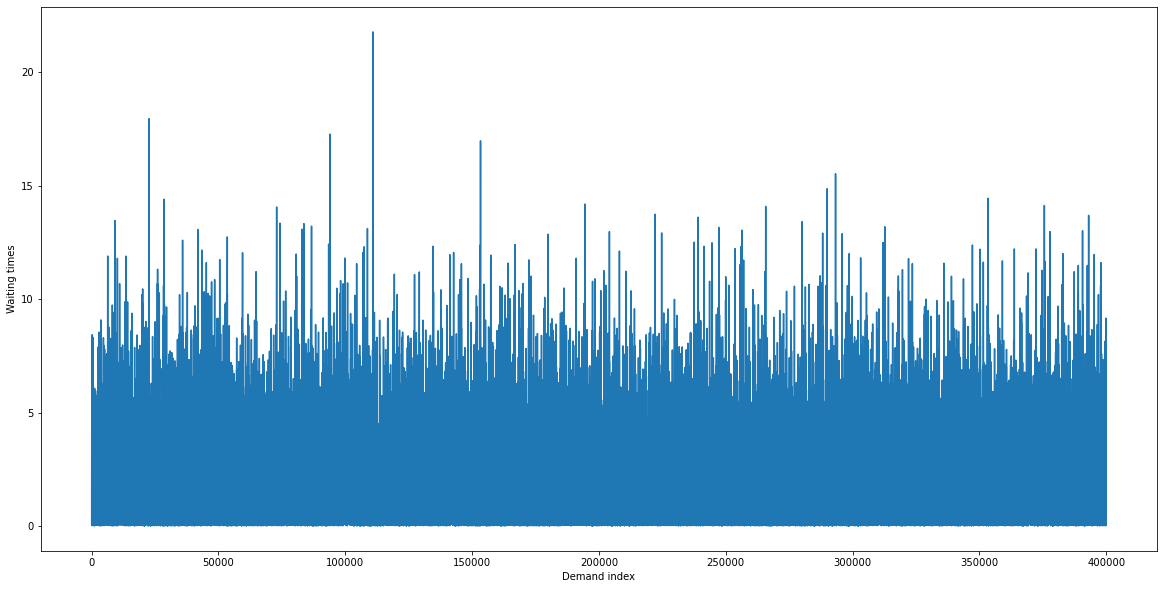

In [61]:
plt.figure(figsize=(20, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

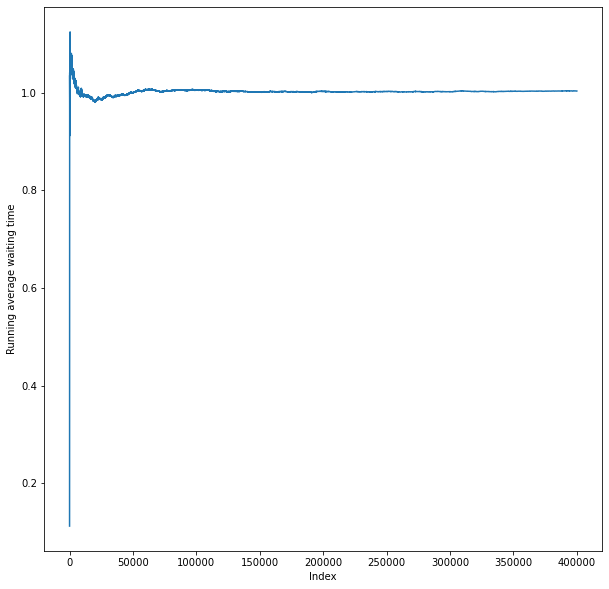

In [62]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), convergence)

plt.title('')
plt.xlabel('Index')
plt.ylabel('Running average waiting time')
plt.show()